In [2]:
from typing import Annotated,Sequence,List,Literal
from pydantic import BaseModel,Field
from langchain_core.messages import HumanMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.tools.arxiv import ArxivQueryRun
from langchain_community.tools.riza.command import ExecPython
from langchain_groq import ChatGroq
from langgraph.types import Command
from langgraph.graph import START,END,StateGraph,MessagesState
from langgraph.prebuilt import create_react_agent

from dotenv import load_dotenv
load_dotenv()

True

In [3]:
# 1 intialize llm

llm =ChatGroq(model='llama-3.3-70b-versatile')

In [4]:
# defineing tools

tool_tavily=TavilySearchResults(max_results=2)

tool_code_interpreter=ExecPython()
tools=[tool_tavily,tool_code_interpreter]

In [5]:
tool_code_interpreter.invoke('give me how many As present in a string of AVYGABAAHKJHDAAAAUHBU?')

'Riza code execution returned a non-zero exit code. The output captured from stderr was:\nTraceback (most recent call last):\n  File "<string>", line 1\n    give me how many As present in a string of AVYGABAAHKJHDAAAAUHBU?\n         ^^\nSyntaxError: invalid syntax\n'

In [46]:
system_prompt = ('''You are a workflow supervisor managing a team of three agents: Prompt Enhancer, Researcher,research papers and Coder. Your role is to direct the flow of tasks by selecting the next agent based on the current stage of the workflow. For each task, provide a clear rationale for your choice, ensuring that the workflow progresses logically, efficiently, and toward a timely completion.

**Team Members**:
1. Enhancer: Use prompt enhancer as the first preference, to Focuse on clarifying vague or incomplete user queries, improving their quality, and ensuring they are well-defined before further processing.
2. Researcher: Specializes in gathering information.
3. research_paper_node: this node helps to gather information about a research paper.
4. Coder: Handles technical tasks related to caluclation, coding, data analysis, and problem-solving, ensuring the correct implementation of solutions.
5. Email Summariser: this nod is responsible to get emails of the user and summarise them.
6. document_create_node: this node on its on do  research based on specific informations and then create an docs and give user the link
**Responsibilities**:
1. Carefully review each user request and evaluate agent responses for relevance and completeness.
2. Continuously route tasks to the next best-suited agent if needed.
3. Ensure the workflow progresses efficiently, without terminating until the task is fully resolved.

Your goal is to maximize accuracy and effectiveness by leveraging each agent’s unique expertise while ensuring smooth workflow execution.
''')


class Supervisor(BaseModel):
    # field is used to give additional information fot the literal 
    # : The colon is used to specify the type of the variable (type hinting). It tells us what kind of value this variable is expected to hold.
    next: Literal['enhancer','researcher','research_paper_node','email_summariser_node','document_create_node','coder']=Field(
        description="specifies the next worker in the pipeline:"
        "'enhancer' for enhancing the user prompt if it is unclear or vague,"
        "'reseracher' for gathering additional information,"
        "'research_paper_node' for gathering information from a research papers on the internet,"
        "'email_summariser_node' this nod is responsible to get emails of the user and summarise them,"
        "'document_create_node' this node will research based on specific informations and then create an docs and gove user the link" 
        "'coder' for handling technical tasks such as calculation, coding, data analysis, and problem-solving"
    )

    reason :str =Field(
        description="the reason for the decision,providing context on why a particular worker was chosen"
    )

In [47]:
def supervisor_node(state:MessagesState) -> Command[Literal['enhancer','researcher','research_paper_node','email_summariser_node','document_create_node','coder']]:
    """
    supervisor node for routing tasks based on the current state and llm response .
    Agrs:
        state (MessageState): the current state containing message history.
    returns:
        Command: A command indicatingthe next state or action
    """

    messages=[
        {'role':'system','content':system_prompt},
    ]+state["messages"]# state['message]- it is the message while taling to the llm

    response = llm.with_structured_output(Supervisor).invoke(messages)
    goto=response.next

    reason=response.reason

    print(f"Current Node:Supervisor -> Goto:{goto}")
    return Command(
        update={
            "messages":[HumanMessage(content=reason,name='supervisor')],
        },
        goto=goto
    )

In [48]:
def enhancer_node(state:MessagesState)->Command[Literal['supervisor']]:
    """
    Enhancer node for refining and clarifying user inputs.

    Args:
        state (MessagesState): The current state containing the conversation history.

    Returns:
        Command: A command to update the state with the enhanced query and route back to the supervisor.
    """
    system_prompt = (
        "You are an advanced query enhancer. Your task is to:\n"
        "Don't ask anything to the user, select the most appropriate prompt"
        "1. Clarify and refine user inputs.\n"
        "2. Identify any ambiguities in the query.\n"
        "3. Generate a more precise and actionable version of the original request.\n"
    )

    messages=[{"role":"system","content":system_prompt},]+state['messages']

    enhanced_query=llm.invoke(messages)

    print("Current node:prompt Enhancer -> goto:supervisor")
    return Command(
        update={
            "message":[HumanMessage(content=enhanced_query.content,name="enhancer")]
        },
        goto="supervisor"
    )

In [49]:
def research_node(state:MessagesState)->Command[Literal['validator']]:
    """
    Research node for leveraging a ReAct agent to process research-related tasks.

    Args:
        state (MessagesState): The current state containing the conversation history.

    Returns:
        Command: A command to update the state with the research results and route to the validator.
    """

    research_agent=create_react_agent(
        llm,
        tools=[tool_tavily],
        state_modifier="You are a researcher. Focus on gathering information and generating content. Do not perform any other tasks"
    )

    result=research_agent.invoke(state)

    return Command(
        update={
            "messages":[HumanMessage(content=result['messages'][-1].content,name='research_node')],
        },
        goto='validator'
    )

In [50]:
def research_paper_node(state:MessagesState)-> Command[Literal['validator']]:
    """
    Research node for leveraging a ReAct agent to process research-related tasks.

    Args:
        state (MessagesState): The current state containing the conversation history.

    Returns:
        Command: A command to update the state with the research results and route to the validator.
    """
    from langchain_community.document_loaders import ArxivLoader
    paper_name=llm.invoke(f"you are a name idetifier bot you responsiblity is to identify the name of the research paper in the entire context of this message just return back the name{state['messages'][-1].content}")
    loader = ArxivLoader(
    query=paper_name.content,
    load_max_docs=2
    )
    docs = loader.get_summaries_as_docs()
    result=docs[0]
   
    result=llm.invoke(f"Sumamrize this research paper{result}")
    return Command(
        update={
            "messages":[HumanMessage(content=result.content,name='research_paper_node')],
        },
        goto='validator'
    )

In [51]:
def code_node(state: MessagesState) -> Command[Literal["validator"]]:
    """
    Coder node for leveraging a ReAct agent to process analyzing, solving math questions, and executing code.

    Args:
        state (MessagesState): The current state containing the conversation history.

    Returns:
        Command: A command to update the state with the research results and route to the validator.
    """

    code_agent = create_react_agent(
        llm,
        tools=[tool_code_interpreter],
        state_modifier=(
            "You are a coder and analyst. Focus on mathematical caluclations, analyzing, solving math questions, "
            "and executing code. Handle technical problem-solving and data tasks."
        )
    )


    result = code_agent.invoke(state)

    print(f"Current Node: Coder -> Goto: validator")

    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="validator",
    )


In [52]:
def email_summariser_node(state:MessagesState)->Command[Literal["validator"]]:
    from googleapiclient.discovery import build
    from google_auth_oauthlib.flow import InstalledAppFlow

    def fetch_emails_with_sender():
        
        SCOPES = ['https://www.googleapis.com/auth/gmail.readonly']
        
         
        flow = InstalledAppFlow.from_client_secrets_file('credentials.json', SCOPES)
        creds = flow.run_local_server(port=0)
        service = build('gmail', 'v1', credentials=creds)
        
        
        results = service.users().messages().list(userId='me', maxResults=10).execute()
        messages = results.get('messages', [])
        
      
        collected_emails = []

 
        for message in messages:
            msg = service.users().messages().get(userId='me', id=message['id']).execute()
            
            
            headers = msg['payload']['headers']
            snippet = msg['snippet']
            
      
            sender = None
            for header in headers:
                if header['name'] == 'From':
                    sender = header['value']
                    break
            
            if sender:
                if '<' in sender:
                    sender_name, sender_email = sender.split('<')
                    sender_email = sender_email.strip('>')
                else:
                    sender_name, sender_email = sender, sender
                
                    collected_emails.append({
                    "sender_name": sender_name.strip(),
                    "sender_email": sender_email,
                    "snippet": snippet
                })
        
        return collected_emails
    
    mails = fetch_emails_with_sender()
    result=[]
    for mail in mails:
        result.append(llm.invoke(f"you task is to summaries this emails from name:{mail['sender_name']} email address:{mail['sender_email']} and the contents needed to to summarised{mail['snippet']}").content)
        result.append('\n')
    result_string = " ".join(result)
    return Command(
        update={
            "messages":[HumanMessage(content=result_string,name='research_paper_node')],
        },
        goto='validator'
    )


In [72]:
def document_create_node(state:MessagesState)-> Command[Literal['validator']]:
    from googleapiclient.discovery import build
    from google.oauth2.service_account import Credentials
    from pprint import pprint

    # Define your service account credentials file
    SERVICE_ACCOUNT_FILE = 'service_account.json'
    SCOPES = ['https://www.googleapis.com/auth/drive', 'https://www.googleapis.com/auth/documents']

    def create_google_doc(title: str, content: str):
        # Authenticate using the service account
        credentials = Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)
        
        # Build the Docs API service
        docs_service = build('docs', 'v1', credentials=credentials)
        drive_service = build('drive', 'v3', credentials=credentials)
        
        # Step 1: Create a new Google Doc
        doc = docs_service.documents().create(body={'title': title}).execute()
        document_id = doc.get('documentId')
        
        # Step 2: Write content to the Google Doc
        requests = [
            {
                'insertText': {
                    'location': {'index': 1},  # Index 1 to insert after the initial blank title
                    'text': content
                }
            }
        ]
        docs_service.documents().batchUpdate(documentId=document_id, body={'requests': requests}).execute()
        
        # Step 3: Get the shareable URL
        # Set the permissions for the document (make it viewable by anyone with the link)
        drive_service.permissions().create(
            fileId=document_id,
            body={'type': 'anyone', 'role': 'reader'},  # 'reader' role for read-only access
        ).execute()
        
        # Retrieve the document's URL
        doc_url = f"https://docs.google.com/document/d/{document_id}/edit"
        return doc_url

    research_agent=create_react_agent(
        llm,
        tools=[tool_tavily],
        state_modifier="You are a researcher. Focus on gathering information and generating content.just gove the text. Do not perform any other tasks"
    )

    result=research_agent.invoke(state)
    title=llm.invoke(f"for the given text {result} generate a samll title")
    title = title.content
    content = (result['messages'][-1].content).content
    doc_url = create_google_doc(title, content)
    print("Google Doc URL:", doc_url)
    return Command(
        update={
            "messages":[HumanMessage(content=result['messages'][-1].content+"Successfully sended the docs",name='research_node')],
        },
        goto='validator'
    )



In [67]:
system_prompt = '''
You are a workflow validator. Your task is to ensure the quality of the workflow. Specifically, you must:
- Review the user's question (the first message in the workflow).
- Review the answer (the last message in the workflow).
- If the answer satisfactorily addresses the question, signal to end the workflow.
- If the answer is inappropriate or incomplete, signal to route back to the supervisor for re-evaluation or further refinement.
Ensure that the question and answer match logically and the workflow can be concluded or continued based on this evaluation.

Routing Guidelines:
1. 'supervisor' Agent: For unclear or vague state messages.
2. Respond with 'FINISH' to end the workflow.
'''


class validator(BaseModel):
    next:Literal['supervisor','FINISH']=Field(
        description="Specifies the next worker in the pipeline: 'supervisor' to continue or 'FINISH' to terminate."
    )

    reason:str=Field(
        description="Reason for the decison"
    )


In [68]:
def validator_node(state:MessagesState)-> Command[Literal['supervisor','__end__']]:
    """
    Validator node for checking if the question and the answer are appropriate.

    Args:
        state (MessagesState): The current state containing message history.

    Returns:
        Command: A command indicating whether to route back to the supervisor or end the workflow.
    """
    user_query=state['messages'][0].content
    agent_query=state['messages'][-1].content
    messages=[{"role":"system","content":system_prompt},
              {"role":'user','content':user_query},
              {"role":'assistant','content':agent_query}
    ]
    result=llm.with_structured_output(validator).invoke(messages)
    goto=result.next
    reason=result.reason

    if goto=='FINISH' or goto==END:
        goto=END
        print("Trasisiton to end")

    else:
        print("Trasition to supervisor")


    print(f"Current Node:Supervisor -> Goto:{goto}")
    return Command(
        update={
            "messages":[HumanMessage(content=reason,name='validator')]
        },
        goto=goto
    )


In [69]:
builder = StateGraph(MessagesState)


builder.add_node("supervisor", supervisor_node)  # Add the supervisor node to the graph
builder.add_node("enhancer", enhancer_node)  # Node for refining and clarifying user inputs
builder.add_node("researcher", research_node)  # Node for handling research-related tasks
builder.add_node("coder", code_node)  # Node for managing coding and analytical tasks
builder.add_node("research_paper_node",research_paper_node)
builder.add_node("email_summariser_node",email_summariser_node)
builder.add_node("document_create_node",document_create_node)
builder.add_node("validator", validator_node)  # Node for managing coding and analytical tasks

builder.add_edge(START, "supervisor")  

graph = builder.compile()


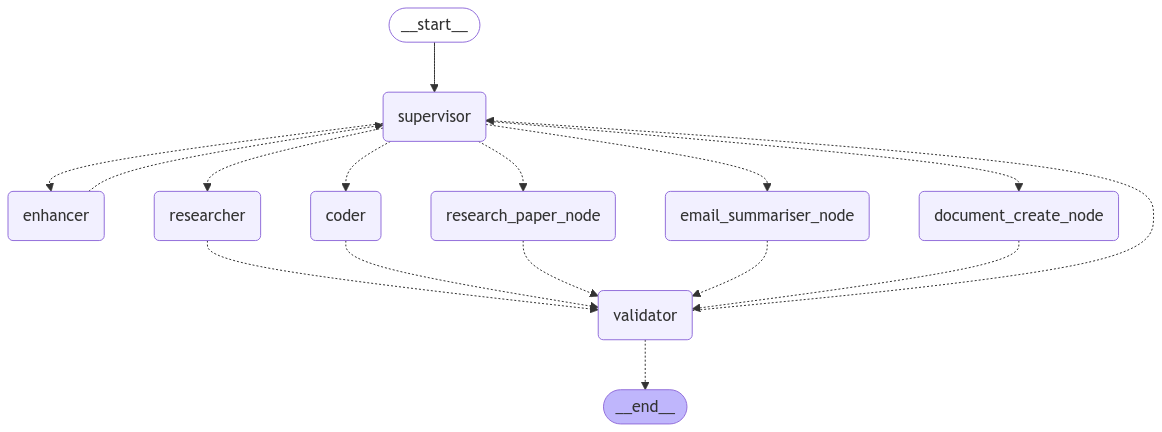

In [70]:

from IPython.display import Image, display # Import for displaying images in a Jupyter Notebook

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [131]:

import pprint

inputs = {
    "messages": [
        ("user", "give me details about the paper lipnet"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        if value is None:
            continue
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint(value, indent=2, width=80, depth=None)
        print()
     

Current Node:Supervisor -> Goto:research_paper_node
"Output from node 'supervisor':"
{ 'messages': [ HumanMessage(content="The user is asking for details about a specific research paper, 'LipNet', which requires gathering information from research papers on the internet.", additional_kwargs={}, response_metadata={}, name='supervisor', id='a5ca8544-c814-4abd-826a-816780e53392')]}

"Output from node 'research_paper_node':"
{ 'messages': [ HumanMessage(content="This research paper introduces LipNet, a deep learning model for lipreading that can decode text from the movement of a speaker's mouth at the sentence level. Unlike previous approaches that focused on word-level classification, LipNet is an end-to-end trainable model that uses spatiotemporal convolutions, a recurrent network, and the connectionist temporal classification loss to map a sequence of video frames to text. The model is trained entirely end-to-end and achieves state-of-the-art results on the GRID corpus, with a 95.2% ac

In [70]:
inputs = {
    "messages": [
        ("user", "Research the impact of climate change on agriculture in Southeast Asia. Based on your findings, propose potential solutions to mitigate its effects on crop production"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        if value is None:
            continue
        pprint.pp(value['messages'][-1].content)
        print()

Current Node:Supervisor -> Goto:researcher
("The user's question requires gathering information on the impact of climate "
 'change on agriculture in Southeast Asia and proposing potential solutions to '
 'mitigate its effects on crop production, which is a complex task that '
 'requires further research and analysis.')

('Based on the search results, some potential solutions to mitigate the '
 'effects of climate change on agriculture in Southeast Asia include:\n'
 '\n'
 '1. Implementing climate-smart agriculture practices, such as using '
 'drought-resistant crop varieties and conservation agriculture.\n'
 '2. Promoting regional cooperation and knowledge sharing among countries to '
 'address the impacts of climate change on agriculture.\n'
 '3. Increasing climate finance for agrifood systems to support smallholder '
 'farmers in adapting to climate change.\n'
 '4. Supporting rural communities in coping with the impacts of climate change '
 'and extreme weather events through initiat

In [63]:
import pprint
inputs = {
    "messages": [
        ("user", "get the emails and give me a summary of them"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        if value is None:
            continue
        pprint.pp(value['messages'][-1].content)
        print()

Current Node:Supervisor -> Goto:email_summariser_node
('The user has requested to get their emails and have them summarized, so the '
 'email_summariser_node is the most suitable next worker in the pipeline.')

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=125351955598-fpvl9e8ppuhdrtplmpgafl14ads81lbs.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A61919%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fgmail.readonly&state=hUTdzHTtgVwCYCnA5spfOpPMbYUEBq&access_type=offline


KeyboardInterrupt: 

In [73]:
import pprint
inputs = {
    "messages": [
        ("user", "give me a poem on rain and put it in a docs and sended to me"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        if value is None:
            continue
        pprint.pp(value['messages'][-1].content)
        print()

Current Node:Supervisor -> Goto:document_create_node
('The user request is to create a poem about rain and send it in a document, '
 'which requires the document_create_node to generate the poem and share the '
 'document link.')

Google Doc URL: https://docs.google.com/document/d/1aI1B_0ShufLUTGRvn8531vi74Pha8RFNgtqPLJxv7pg/edit
("Here's a poem about rain:\n"
 '\n'
 'Softly falls the rain tonight\n'
 'A soothing melody, a gentle hush\n'
 'The droplets on the roof, a rhythmic beat\n'
 'As the rain washes away, my worries retreat\n'
 '\n'
 'The smell of wet earth rises high\n'
 'Fresh and clean, the scent touches the sky\n'
 'In the rain, I find my peace\n'
 "A calming balm, my soul's release\n"
 '\n'
 "If you'd like to explore more poems about rain, you can visit "
 'https://poemanalysis.com/poems-about/rain/ or '
 'https://www.poemhunter.com/poems/rain/ for a collection of poems from '
 'various poets and genres.Successfully sended the docs')

Trasisiton to end
Current Node:Supervisor